In [15]:
from understatscraper import Understat
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from mplsoccer.pitch import Pitch, VerticalPitch

In [61]:
def shotmap(match_id):
    understat = Understat()
    df = understat.single_match(match_id)
    df[['X','Y','xG']] = df[['X','Y','xG']].apply(pd.to_numeric,axis=1)
    df['date'] = pd.to_datetime(df['date'])
    df['date'] = df['date'].dt.strftime('%Y-%m-%d')
    df['goal'] = np.where(df['result']=='Goal',1,0)
    df[['X','Y']] = df[['X','Y']]*100
    own = df[df['result']=='OwnGoal']
    df = df[df['result']!='OwnGoal']

    pitch = Pitch(pad_bottom=0.5,
                     goal_type='box',
                     goal_alpha=0.8,
                     pitch_type='opta',
                     pitch_color='#263a4d')

    fig, ax = pitch.draw(figsize=(14, 12))
    fig.patch.set_facecolor('#263a4d')


    re = pitch.scatter(100-df[(df['h_a']=='h') & (df['result']=='Goal')]['X'],100-df[(df['h_a']=='h') & (df['result']=='Goal')]['Y'],s=(df[(df['h_a']=='h') & (df['result']=='Goal')]['xG']*720)+100,
                   c='#c9897b',marker='h',edgecolors='#383838',ax=ax,label='Goal')

    re1 = pitch.scatter(100-df[(df['h_a']=='h') & (df['result']!='Goal')]['X'],100-df[(df['h_a']=='h') & (df['result']!='Goal')]['Y'],s=(df[(df['h_a']=='h') & (df['result']!='Goal')]['xG']*720)+100,
                   c='#808080',marker='h',edgecolors='#383838',ax=ax,label='Missed')

    re2 = pitch.scatter(df[(df['h_a']=='a') & (df['result']=='Goal')]['X'],df[(df['h_a']=='a') & (df['result']=='Goal')]['Y'],s=(df[(df['h_a']=='a') & (df['result']=='Goal')]['xG']*720)+100,
                   c='#c9897b',marker='h',edgecolors='#383838',ax=ax,label='Goal')

    re3 = pitch.scatter(df[(df['h_a']=='a') & (df['result']!='Goal')]['X'],df[(df['h_a']=='a') & (df['result']!='Goal')]['Y'],s=(df[(df['h_a']=='a') & (df['result']!='Goal')]['xG']*720)+100,
                   c='#808080',marker='h',edgecolors='#383838',ax=ax,label='Missed')

    re4 = pitch.scatter(own[(own['h_a']=='a') & (own['result']=='OwnGoal')]['X'],own[(own['h_a']=='a') & (own['result']=='OwnGoal')]['Y'],s=(own[(own['h_a']=='a') & (own['result']=='OwnGoal')]['xG']*720)+100,
                   c='#9e443e',marker='h',edgecolors='#383838',ax=ax)

    re5 = pitch.scatter(100-own[(own['h_a']=='h') & (own['result']=='OwnGoal')]['X'],100-own[(own['h_a']=='h') & (own['result']=='OwnGoal')]['Y'],s=(own[(own['h_a']=='h') & (own['result']=='OwnGoal')]['xG']*720)+100,
                   c='#9e443e',marker='h',edgecolors='#383838',ax=ax)

    # Scatter plot for goals, missed shots and own goals


    if len(own)!=0:
        colors = ['#9e443e','#808080','#c9897b']
        for y,c in zip(np.arange(5, 20, 5).tolist(),colors):
            plt.scatter(90,y,s=300,color=c,marker='h')
   
        xx = np.arange(93, 96, 1).tolist()[::-1]
        yy = np.arange(5, 20, 5).tolist()
        xx_yy = ['Own Goal', 'Missed', 'Goal']
        for i in range(len(xx)):
            plt.text(xx[i], yy[i], xx_yy[i], fontsize=12, color="white",ha="center", va="center",fontweight='bold')
    
    else:
        colors = ['#808080','#c9897b']
        for y,c in zip(np.arange(10, 20, 5).tolist(),colors):
            plt.scatter(90,y,s=300,color=c,marker='h')
        
        xx = np.arange(93, 95, 1).tolist()
        yy = np.arange(10, 20, 5).tolist()[::-1]
        xx_yy = ['Goal', 'Missed']
        for i in range(len(xx)):
            plt.text(xx[i], yy[i], xx_yy[i], fontsize=12, color="white",ha="center", va="center",fontweight='bold')

    # scatter plot for xG
    mSize = [0.10,0.2,0.4,0.6,0.8]
    mSizeS = [720 * i for i in mSize]
    mSizeS = [100 + i for i in mSizeS]

    mx = [3,3,3,3,3]
    my = [1.8,4,6.8,10,13.75]

    plt.scatter(mx,my,s=mSizeS,edgecolor='black',marker='h')
    for i in range(len(mx)):
        plt.text(mx[i]+3.2,my[i],mSize[i],fontsize=12,c='white',ha='center',va='center',fontweight='bold')

    plt.figtext(0.0825,0.25,'xG',fontweight='bold',fontsize=12,color='white')

    h_xg = sum(df[df['h_a']=='h']['xG'])
    a_xg = sum(df[df['h_a']=='a']['xG'])
    lst_xg = [h_xg,a_xg]

    h_conversion = len(df[(df['result']=='Goal') & (df['h_a']=='h')])/len(df[df['h_a']=='h'])
    a_conversion = len(df[(df['result']=='Goal') & (df['h_a']=='a')])/len(df[df['h_a']=='a'])
    lst_conversion = [h_conversion,a_conversion]

    h_xg_shot = h_xg/len(df[df['h_a']=='h'])
    a_xg_shot = a_xg/len(df[df['h_a']=='a'])
    lst_xg_shot = [h_xg_shot,a_xg_shot]

    for x,xg in zip(np.arange(0.4,0.601,0.2).tolist(),lst_xg):
        plt.text(x, 0.8450, "xG: {:.2f}".format(xg), size=20,
         ha="center", va="center",transform=ax.transAxes,
         color="#ff6361",fontweight='bold',
         bbox=dict(boxstyle="circle",color='#ff6361',alpha=0.10)
         )
    
    for x,con in zip(np.arange(0.4,0.601,0.2).tolist(),lst_conversion):
        plt.text(x, 0.6550, "Conversion: {:.2f}".format(con), size=10.5,
         ha="center", va="center",transform=ax.transAxes,
         color="#baffc9",fontweight='bold',
         bbox=dict(boxstyle="circle",color='#baffc9',alpha=0.10)
         )
    
    for x,xg_shot in zip(np.arange(0.4,0.601,0.2).tolist(),lst_xg_shot):
        plt.text(x, 0.4650, "xG per Shot: {:.2f}".format(xg_shot), size=10,
         ha="center", va="center",transform=ax.transAxes,
         color="#ffffba",fontweight='bold',
         bbox=dict(boxstyle="circle",color='#ffffba',alpha=0.10)
         )

    h_goal = len(df[(df['result']=='Goal') &(df['h_a']=='h')]) + len(own[(own['result']=='OwnGoal') & (own['h_a']=='a')])
    a_goal = len(df[(df['result']=='Goal') &(df['h_a']=='a')]) + len(own[(own['result']=='OwnGoal') & (own['h_a']=='h')])
    font = {'family': 'Comic Sans MS',
       'color': 'black',
       'weight': 'bold',
       'size': 16
       }
    plt.title(df['date'].values[0] + " | " + df['h_team'].values[0] + '-' + df['a_team'].values[0] + ': ' + str(h_goal) + "-"+
          str(a_goal)+ " | " + "Shot Map",fontdict=font,color='white')
    
    plt.figtext(0.03,0.85,'@seripenaltilar',fontweight='bold',fontsize=12,color='white')

    plt.show()

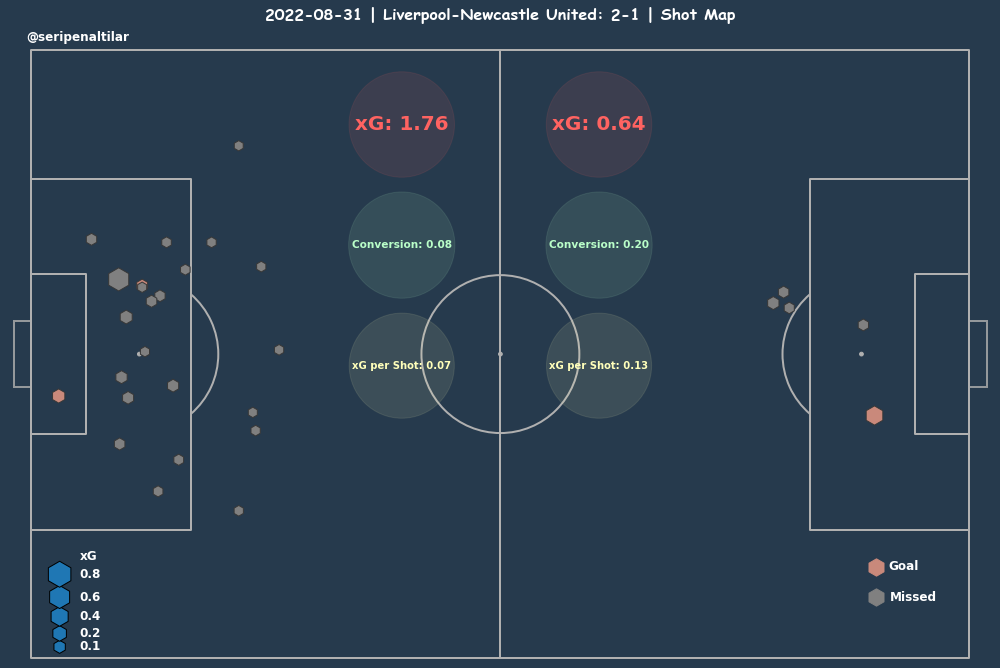

In [86]:
shotmap(18250)